<a href="https://colab.research.google.com/github/sowmyaracha/Travel-Search-Agency/blob/main/travel_search_agency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Travel Booking Prediction

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load data
df = pd.read_csv('/content/train_small (1).csv')

In [3]:
# Remove leaky features
df = df.drop(['clicked', 'booking_value'], axis=1, errors='ignore')

# Remove rows with missing target
df = df.dropna(subset=['booked'])

In [4]:
# Handle timestamp
if 'timestamp' in df.columns:
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    df['hour'] = df['timestamp'].dt.hour
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['month'] = df['timestamp'].dt.month
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    df = df.drop('timestamp', axis=1)

In [5]:
# Get numeric features only
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if 'booked' in numeric_cols:
    numeric_cols.remove('booked')

# Handle missing values
for col in numeric_cols:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(df[col].median())

# Keep only numeric features
df = df[numeric_cols + ['booked']].dropna()

In [6]:
# Separate features and target
X = df.drop('booked', axis=1)
y = df['booked'].astype(int)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [7]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Balance training data
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

In [8]:
# Train models
models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=100, max_depth=10, random_state=42, n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42
    ),
    'Logistic Regression': LogisticRegression(
        max_iter=1000, random_state=42, n_jobs=-1
    )
}

results = {}
for name, model in models.items():
    model.fit(X_train_balanced, y_train_balanced)
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

    results[name] = {
        'accuracy': metrics.accuracy_score(y_test, y_pred),
        'precision': metrics.precision_score(y_test, y_pred),
        'recall': metrics.recall_score(y_test, y_pred),
        'f1': metrics.f1_score(y_test, y_pred),
        'roc_auc': metrics.roc_auc_score(y_test, y_pred_proba),
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

In [9]:
# Display results
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy']*100 for m in results.keys()],
    'Precision': [results[m]['precision']*100 for m in results.keys()],
    'Recall': [results[m]['recall']*100 for m in results.keys()],
    'F1-Score': [results[m]['f1']*100 for m in results.keys()],
    'ROC-AUC': [results[m]['roc_auc'] for m in results.keys()]
}).sort_values('F1-Score', ascending=False)

print(comparison_df.to_string(index=False))

              Model  Accuracy  Precision    Recall  F1-Score  ROC-AUC
      Random Forest 85.959292   9.767314 48.816467 16.277740 0.797071
Logistic Regression 70.708078   7.020383 77.392796 12.873039 0.810430
  Gradient Boosting 97.161740  25.000000  0.754717  1.465201 0.805435


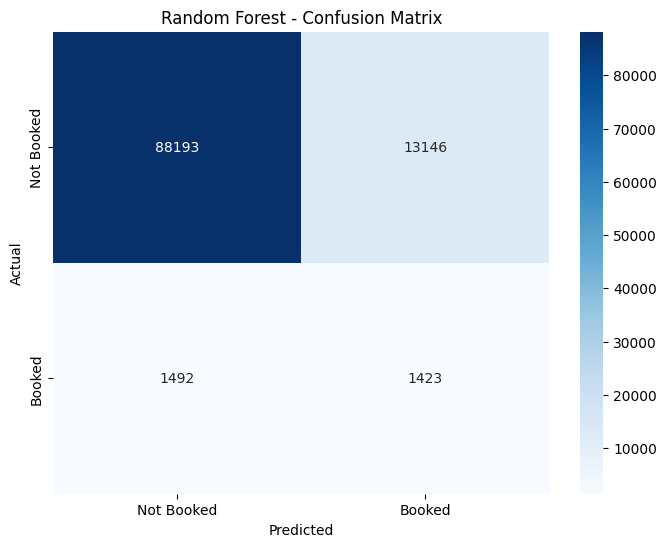

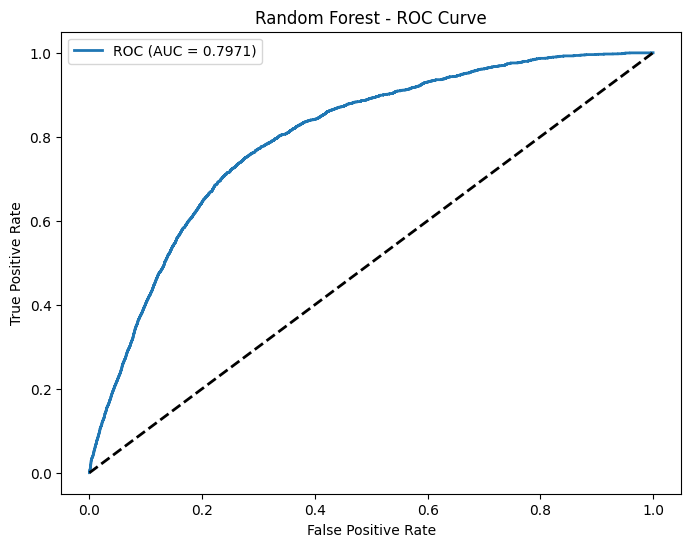

In [10]:
# Best model analysis
best_model_name = comparison_df.iloc[0]['Model']
best_results = results[best_model_name]

# Confusion matrix
cm = metrics.confusion_matrix(y_test, best_results['y_pred'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Booked', 'Booked'],
            yticklabels=['Not Booked', 'Booked'])
plt.title(f'{best_model_name} - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# ROC curve
fpr, tpr, _ = metrics.roc_curve(y_test, best_results['y_pred_proba'])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label=f'ROC (AUC = {best_results["roc_auc"]:.4f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'{best_model_name} - ROC Curve')
plt.legend()
plt.show()

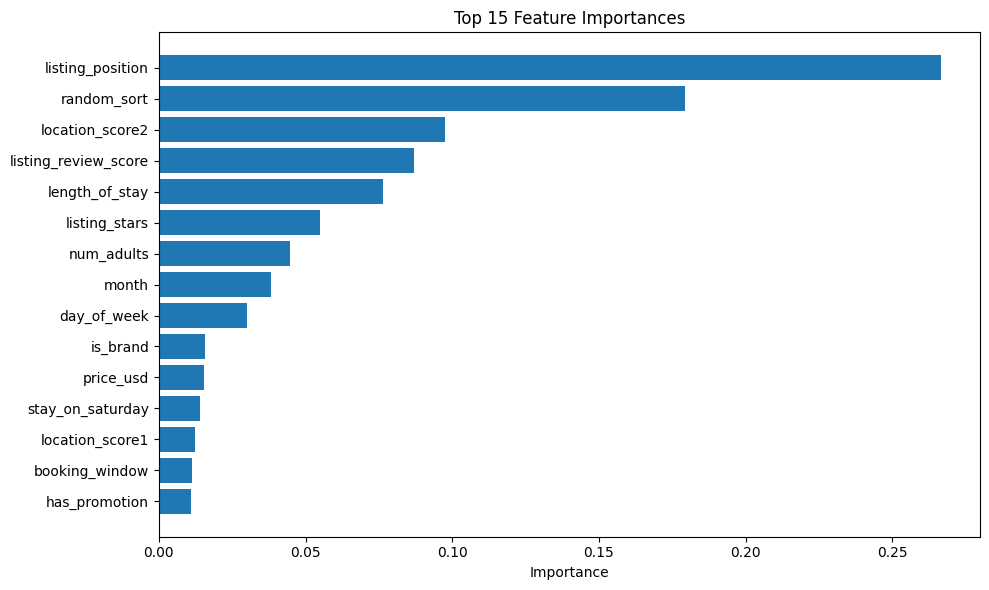

In [11]:
# Feature importance (for Random Forest)
if best_model_name == 'Random Forest':
    feature_imp = pd.DataFrame({
        'Feature': X.columns,
        'Importance': models[best_model_name].feature_importances_
    }).sort_values('Importance', ascending=False).head(15)

    plt.figure(figsize=(10, 6))
    plt.barh(feature_imp['Feature'], feature_imp['Importance'])
    plt.xlabel('Importance')
    plt.title('Top 15 Feature Importances')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

In [12]:
# Summary
print(f"\nBest Model: {best_model_name}")
print(f"Accuracy:  {best_results['accuracy']*100:.2f}%")
print(f"Precision: {best_results['precision']*100:.2f}%")
print(f"Recall:    {best_results['recall']*100:.2f}%")
print(f"F1-Score:  {best_results['f1']*100:.2f}%")
print(f"ROC-AUC:   {best_results['roc_auc']:.4f}")


Best Model: Random Forest
Accuracy:  85.96%
Precision: 9.77%
Recall:    48.82%
F1-Score:  16.28%
ROC-AUC:   0.7971
